In [2]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [18]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [19]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [20]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [21]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

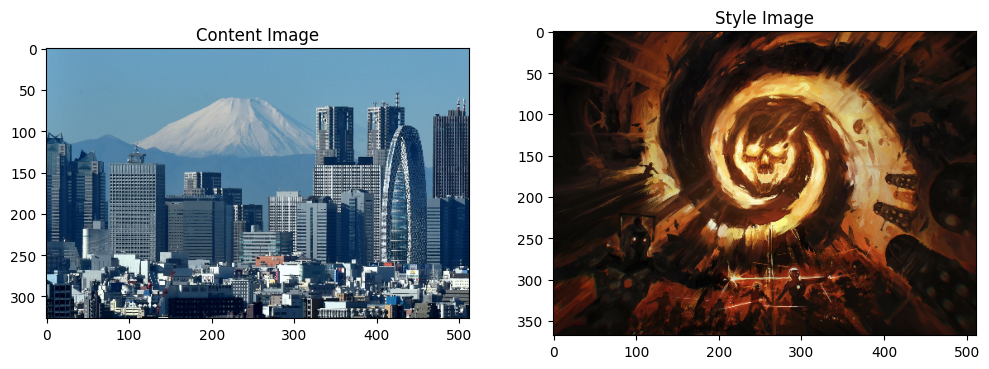

In [22]:
content_image = load_img("images\\tokyo.jpg")
style_image = load_img("images\\doomsday.jpg")

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

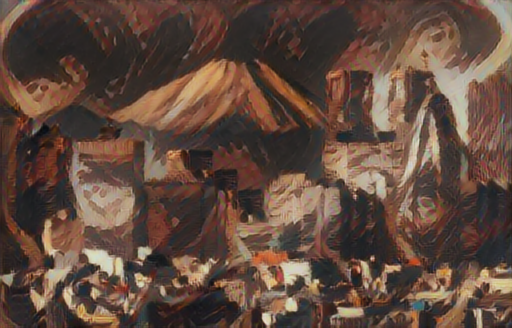

In [23]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [24]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [25]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('fireboat', np.float32(0.62917686)),
 ('fountain', np.float32(0.24034902)),
 ('steel_arch_bridge', np.float32(0.027395954)),
 ('pier', np.float32(0.014388109)),
 ('bell_cote', np.float32(0.007069122))]

In [26]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_layer_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [27]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [28]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

### Investigation 1

I was not sure what VGG model actually does - it's a pretrained model (Visual Geometry Group) with 19 layers - used for object recognition, pretrained on ImageNet - a dataset containing more than 14 million images. VGG16 has about 138 million total parameters in it!

according to https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/


In [29]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

C:\Users\bense\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_158']
Received: inputs=Tensor(shape=(1, 368, 512, 3))
  warnings.warn(msg)


block1_conv1
  shape:  (1, 368, 512, 64)
  min:  0.0
  max:  796.1176
  mean:  16.595142

block2_conv1
  shape:  (1, 184, 256, 128)
  min:  0.0
  max:  3868.1077
  mean:  86.39581

block3_conv1
  shape:  (1, 92, 128, 256)
  min:  0.0
  max:  5704.4585
  mean:  103.12483

block4_conv1
  shape:  (1, 46, 64, 512)
  min:  0.0
  max:  13152.266
  mean:  393.2898

block5_conv1
  shape:  (1, 23, 32, 512)
  min:  0.0
  max:  2018.6204
  mean:  30.713957



In [30]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [32]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [33]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

C:\Users\bense\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_180']
Received: inputs=Tensor(shape=(1, 327, 512, 3))
  warnings.warn(msg)


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0012857425
    max:  14997.592
    mean:  1099.4937

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  334844.03
    mean:  30696.178

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  1039660.44
    mean:  30812.312

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  12014914.0
    mean:  420576.97

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  237151.78
    mean:  2837.9573

Contents:
   block5_conv2
    shape:  (1, 20, 32, 512)
    min:  0.0
    max:  1341.6499
    mean:  19.416834


In [34]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)

C:\Users\bense\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_180']
Received: inputs=Tensor(shape=(1, 368, 512, 3))
  warnings.warn(msg)


In [35]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [36]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4

In [18]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [19]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

runs for a long ime - be careful!

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [23]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [24]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy() == tf.image.total_variation(image).numpy()

In [26]:
total_variation_weight=30
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

In [27]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save("images\\"+file_name)

### Experimentation 1
Tried modifying optimizer Adam's learning rate to be lower - typically worked better on the classification NN so interesting to test

also lowered epochs to 5 so it doesnt run forever

In [29]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.99, epsilon=1e-1)

In [30]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

### Experiment

Trying to create a simple function that can be modified easily to produce new images

In [76]:
def generate_stylized_image(content_image, style_image, 
                            opt=tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1),     
                            style_weight=1e-2,
                            content_weight=1e4,
                            total_variation_weight=30,
                            epochs=10, steps_per_epoch=100):
    
    content_image = load_img(content_image)
    style_image = load_img(style_image)

    opt = opt

    def tensor_to_image(tensor):
        tensor = tensor*255
        tensor = np.array(tensor, dtype=np.uint8)
        if np.ndim(tensor)>3:
            assert tensor.shape[0] == 1
            tensor = tensor[0]
        return PIL.Image.fromarray(tensor)
    
    
    def clip_0_1(image):
        return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    
    def vgg_layers(layer_names):
        """ Creates a VGG model that returns a list of intermediate output values."""
        # Load our model. Load pretrained VGG, trained on ImageNet data
        tf.keras.backend.clear_session()
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False

        outputs = [vgg.get_layer(name).output for name in layer_names]

        model = tf.keras.Model([vgg.input], outputs)
        return model
    
    def gram_matrix(input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
        return result/(num_locations)


    
    content_layers = ['block5_conv2'] 

    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1', 
                    'block4_conv1', 
                    'block5_conv1']

    
    num_content_layers = len(content_layers)
    num_style_layers = len(style_layers)

    class StyleContentModel(tf.keras.models.Model):
        def __init__(self, style_layers, content_layers):
            super(StyleContentModel, self).__init__()
            self.vgg = vgg_layers(style_layers + content_layers)
            self.style_layers = style_layers
            self.content_layers = content_layers
            self.num_style_layers = len(style_layers)
            self.vgg.trainable = False

        def call(self, inputs):
            "Expects float input in [0,1]"
            inputs = inputs*255.0
            preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
            outputs = self.vgg(preprocessed_input)
            style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                            outputs[self.num_style_layers:])

            style_outputs = [gram_matrix(style_output)
                            for style_output in style_outputs]

            content_dict = {content_name: value
                            for content_name, value
                            in zip(self.content_layers, content_outputs)}

            style_dict = {style_name: value
                        for style_name, value
                        in zip(self.style_layers, style_outputs)}

            return {'content': content_dict, 'style': style_dict}

    extractor = StyleContentModel(style_layers, content_layers)
    
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']
    
    def style_content_loss(outputs):
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                            for name in style_outputs.keys()])
        style_loss *= style_weight / num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                                for name in content_outputs.keys()])
        content_loss *= content_weight / num_content_layers
        loss = style_loss + content_loss
        return loss



    image = tf.Variable(content_image)

    @tf.function()
    def train_step(image):
        with tf.GradientTape() as tape:
            outputs = extractor(image)
            loss = style_content_loss(outputs)
            loss += total_variation_weight*tf.image.total_variation(image)

        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))

    start = time.time()
    
    
    step = 0
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            train_step(image)
            print(".", end='', flush=True)
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))
        print("Train step: {}".format(step))

    end = time.time()
    print("Total time: {:.1f}".format(end-start))
    

### Investigation

Getting UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_132']

Honestly i have no idea but it still works so -

Actually the given code gives me that warning too so I'm not going to worry about it

### Investigation Again:

for var in opt.variables:
    var.assign(tf.zeros_like(var))

^ was added to above function because the optimizer would be reused if I don't pass a new one in as an argument, and the images tensors would for some reason confuse it, so this resets the optimizer's variables as to allow me to call the function multiple times without rerunning the function cell each time.

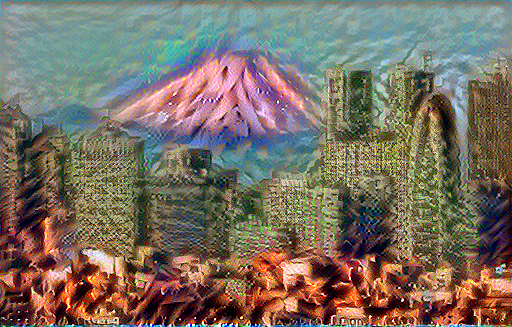

Train step: 200
Total time: 171.0


In [46]:
generate_stylized_image("images\\tokyo.jpg", "images\\doomsday.jpg", epochs=2, steps_per_epoch=100)

### Experimentation 

Weights

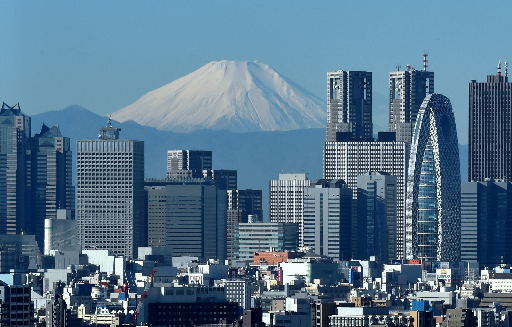

Train step: 200
Total time: 195.8


In [58]:
generate_stylized_image("images\\tokyo.jpg", "images\\doomsday.jpg", style_weight=10, epochs=2, steps_per_epoch=100)

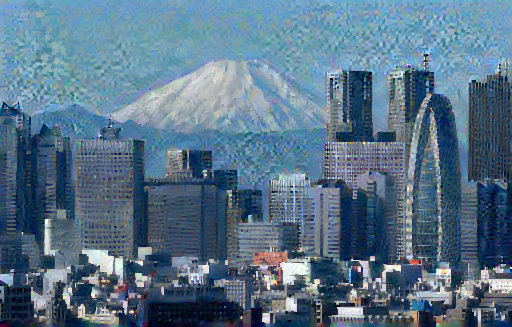

Train step: 200
Total time: 190.3


In [51]:
generate_stylized_image("images\\tokyo.jpg", "images\\doomsday.jpg", style_weight=0.00001, epochs=2, steps_per_epoch=100)

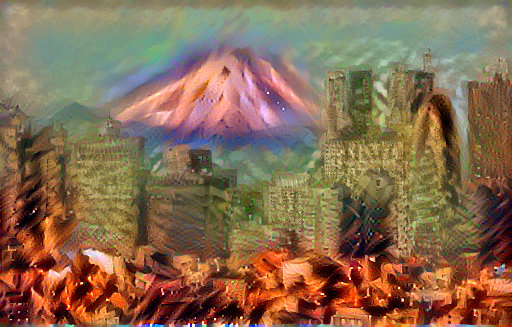

Train step: 200
Total time: 214.6


In [77]:
generate_stylized_image("images\\tokyo.jpg", "images\\doomsday.jpg", total_variation_weight=1000, epochs=2, steps_per_epoch=100)

### Experimentation 

Tried using stylized image as the content_image, and a plain image as a style_image

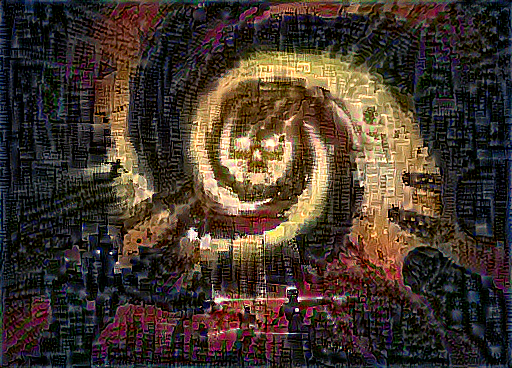

Train step: 50
Total time: 56.4


In [16]:
generate_stylized_image("images\\doomsday.jpg", "images\\tokyo.jpg", opt=tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1), epochs=2, steps_per_epoch=25)

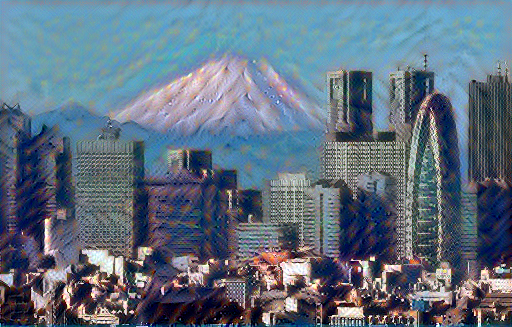

Train step: 500
Total time: 451.3


In [31]:
import time
start = time.time()

epochs = 5
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))